In [1]:
# Install Pytorch
#%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
#%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
%pip list | grep "transformers\\|datasets\\|accelerate\\|evaluate\\|bitsandbytes\\|huggingface-hub\\|trl\\|peft"

accelerate                1.6.0
bitsandbytes              0.45.5
datasets                  3.5.0
evaluate                  0.4.3
huggingface-hub           0.30.2
peft                      0.15.1
transformers              4.51.1
trl                       0.18.1
Note: you may need to restart the kernel to use updated packages.


### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Text Classification:


#### 1. Text Generation with Classification Label as part of text
- **Approach**: Train the model to generate text that naturally appends the classification label at the end.
- **Input**: "Lorem ipsum dolor sit amet, consectetur adipiscing elit"
- **Output**: "Lorem ipsum dolor sit amet, consectetur adipiscing elit 0.25"
- **Use Case**: This method is useful for classifiying text


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "Lorem ipsum dolor sit amet, consectetur adipiscing elit").
- **Output**: Direct classification (e.g., "0.25", "0.50").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [4]:
#device_map="DDP" # for DDP and running with `accelerate launch test_sft.py`
device_map='auto' # for PP and running with `python test_sft.py`

if device_map == "DDP":
    device_string = PartialState().process_index
    device_map={'':device_string}

In [5]:
#from google.colab import userdata
#hugginface_token = userdata.get('huggingface')
#!huggingface-cli login --token $hugginface_token

###### Imports

In [6]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from scipy.stats import pearsonr
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using pip by running this in a notebook cell:

!pip install kaggle
You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called kaggle.json to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell (e.g., creds = '{"username":"xxx","key":"xxx"}'):


In [7]:
#creds = '{"username":"' + userdata.get('kaggle_user') + '","key":"' + userdata.get('kaggle_key') + '"}'

Then execute this cell (this only needs to be run once):

Now you can download datasets from Kaggle.

add Codeadd Markdown
path = Path('us-patent-phrase-to-phrase-matching')
add Codeadd Markdown
And use the Kaggle API to download the dataset to that path, and extract it:

In [8]:
from pathlib import Path
path = Path('emotion_20250602.xlsx')

!ls {path}

df = pd.read_excel(path)

minval = df['전국관객수'].min()
maxval = df['전국관객수'].max()
print(minval, maxval)

df['label'] = (df['전국관객수'] - minval)/(maxval-minval)
df = df.drop(columns=['전국관객수', 'kgmid'])


emotion_20250602.xlsx
0.3621977114020457 1.207641691876943


In [9]:
df

,tvt400,불평/불만,환영/호의,감동/감탄,지긋지긋,고마움,슬픔,화남/분노,존경,기대감,...,부담/안_내킴,서러움,재미없음,불쌍함/연민,놀람,행복,불안/걱정,기쁨,안심/신뢰,label
0,train,0.174790,0.279246,0.258970,0.076540,0.121532,0.195747,0.181100,0.094945,0.264185,...,0.098171,0.087064,0.036063,0.249264,0.265627,0.230219,0.327081,0.260991,0.202779,0.972744
1,train,0.208250,0.162187,0.153258,0.087999,0.065450,0.116708,0.234592,0.077408,0.244981,...,0.116352,0.057835,0.038203,0.145516,0.275861,0.083403,0.376146,0.104432,0.175294,0.882239
2,train,0.202272,0.165005,0.216625,0.072793,0.063490,0.197697,0.241142,0.057188,0.217454,...,0.107604,0.085504,0.032046,0.198102,0.400492,0.152921,0.383097,0.166854,0.122432,0.552808
3,train,0.148007,0.231017,0.240267,0.072103,0.101936,0.220867,0.183165,0.090769,0.229744,...,0.106405,0.086497,0.028859,0.277732,0.303543,0.178273,0.393134,0.192071,0.183586,0.770501
4,train,0.150207,0.248545,0.233666,0.077220,0.110328,0.205734,0.149229,0.077475,0.280942,...,0.117007,0.101359,0.037965,0.251147,0.287929,0.205619,0.370042,0.229531,0.207904,0.756732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,test,0.242792,0.217209,0.214950,0.105769,0.093679,0.188687,0.222696,0.072618,0.250586,...,0.131291,0.103876,0.055125,0.221241,0.293020,0.180223,0.334699,0.211381,0.168577,0.603916
396,test,0.231344,0.237629,0.259239,0.122188,0.106767,0.194087,0.210988,0.077272,0.257205,...,0.138482,0.116121,0.063890,0.230271,0.257095,0.232971,0.296181,0.257756,0.192718,0.849707
397,test,0.394425,0.180521,0.081693,0.148694,0.063635,0.182845,0.485353,0.061155,0.250058,...,0.161498,0.098319,0.029600,0.284994,0.269449,0.056531,0.490351,0.081894,0.189227,0.390156
398,test,0.228850,0.216431,0.183386,0.115554,0.086573,0.096360,0.244332,0.091098,0.227119,...,0.117313,0.063685,0.041705,0.179401,0.261997,0.121082,0.290515,0.152731,0.189348,0.887084


In [10]:
cols = list(df.columns)[1:-1]
print(len(cols))
d_train = []
d_val = []
for i,row in df.iterrows():
    vec = [row[c] for c in cols]
    d_dict = {
        'key': i,
        'inputs_embeds': vec,
        'labels': row['label']
    }
    if row['tvt400'] == 'train':
        d_train.append(d_dict)
    else:
        d_val.append(d_dict)

44


In [11]:
import json
with open("emotion_train.jsonl", "w") as f:
    for item in d_train:
        json_string = json.dumps(item)
        f.write(json_string + "\n")
with open("emotion_val.jsonl", "w") as f:
    for item in d_val:
        json_string = json.dumps(item)
        f.write(json_string + "\n")

In [12]:
dataset_train = Dataset.from_json('emotion_train.jsonl')
dataset_val = Dataset.from_json('emotion_val.jsonl')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

* Add also a numeric 0,1,2,3,4 version of label since we will need it later for fine tuning. We can save it in 'score_category'

* Suppose you want to decode later

### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [13]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train,
    'val': dataset_val,
})
dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'inputs_embeds', 'labels'],
        num_rows: 320
    })
    val: Dataset({
        features: ['key', 'inputs_embeds', 'labels'],
        num_rows: 80
    })
})

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [14]:
from typing import Callable, List, Optional, Tuple, Union
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.modeling_outputs import (
    #BaseModelOutputWithPast,
    #CausalLMOutputWithPast,
    #QuestionAnsweringModelOutput,
    #SequenceClassifierOutputWithPast,
    SequenceClassifierOutput,
    #TokenClassifierOutput,
)
from transformers.models.llama import LlamaModel
from torch import nn

class EmotionRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_labels = 1
        self.hidden_size = 44
        self.score1 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.score2 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.score3 = nn.Linear(self.hidden_size, self.hidden_size//2, bias=True)
        self.score4 = nn.Linear(self.hidden_size//2, self.hidden_size//2, bias=True)
        self.score5 = nn.Linear(self.hidden_size//2, self.hidden_size//2, bias=True)
        self.score6 = nn.Linear(self.hidden_size//2, self.hidden_size//4, bias=True)
        self.score = nn.Linear(self.hidden_size//4, self.num_labels, bias=False)
        #self.activation = nn.Sigmoid()
        self.activation = nn.Mish()

    def forward(
        self,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        hidden_states = inputs_embeds
        #print('#### inputs_embeds =', inputs_embeds.shape)
        hidden_states = self.score1(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.score2(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.score3(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.score4(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.score5(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.score6(hidden_states)
        hidden_states = self.activation(hidden_states)
        logits = self.score(hidden_states)
        #print('#### logits=', logits.shape)

        pooled_logits = logits

        return SequenceClassifierOutput(
            loss=None,
            logits=pooled_logits,
        )

In [15]:
model = EmotionRegression(
    #device_map=device_map,
)

model

EmotionRegression(
  (score1): Linear(in_features=44, out_features=44, bias=True)
  (score2): Linear(in_features=44, out_features=44, bias=True)
  (score3): Linear(in_features=44, out_features=22, bias=True)
  (score4): Linear(in_features=22, out_features=22, bias=True)
  (score5): Linear(in_features=22, out_features=22, bias=True)
  (score6): Linear(in_features=22, out_features=11, bias=True)
  (score): Linear(in_features=11, out_features=1, bias=False)
  (activation): Mish()
)

* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

# define which metrics to compute for evaluation
* We will use balanced accuracy and accuracy for simplicity

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #print('####')

    predictions = predictions.squeeze()
    #print('predictions =', predictions.shape)
    #print('labels =', labels.shape)
    pearson, _ = pearsonr(predictions, labels)
    return {'pearson': pearson}

    try:
        # it's a classification task, take the argmax
        predictions_processed = np.argmax(predictions, axis=1)

        # Calculate Pearson correlation
        pearson, _ = pearsonr(predictions_processed, labels)

        return {'pearson': pearson}
    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        return {'pearson': None}

### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [17]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #print('######')
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')
        #logits = torch.clamp(logits, min=0, max=1)
        #logits = torch.squeeze(logits)
        labels = torch.unsqueeze(labels, dim=1)
        #print('logits.size =', logits.size)
        #print('labels.size =', labels.size)
        #print('labels =', labels)

        # Compute custom loss with class weights for imbalanced data handling
        #if self.class_weights is not None:
        #    loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        #else:
        #    loss = F.cross_entropy(logits, labels)
        loss = F.mse_loss(logits, labels)
        #loss = F.binary_cross_entropy(logits, labels, reduction='none')
        #loss = F.binary_cross_entropy(logits, labels)
        #print('loss =', loss)

        #return (loss, outputs)
        #return (loss, logits, labels)
        #return loss
        return (loss, outputs) if return_outputs else loss


In [18]:
class CustomTrainer2(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #print('######')
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')
        #logits = torch.clamp(logits, min=0, max=1)
        #logits = torch.squeeze(logits)
        labels = torch.unsqueeze(labels, dim=1)
        #print('logits.size =', logits.size)
        #print('labels.size =', labels.size)
        #print('labels =', labels)

        # Compute custom loss with class weights for imbalanced data handling
        #if self.class_weights is not None:
        #    loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        #else:
        #    loss = F.cross_entropy(logits, labels)
        #loss = F.mse_loss(logits, labels)
        loss = F.binary_cross_entropy(logits, labels)
        #print('loss =', loss)

        #return (loss, outputs)
        #return (loss, logits, labels)
        #return loss
        return (loss, outputs) if return_outputs else loss

# define training args

In [19]:
training_args = TrainingArguments(
    output_dir = 'emotion_regression',
    learning_rate = 1e-3,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 8,
    logging_steps = 10,
    num_train_epochs = 20,
    weight_decay = 0.10,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = False,
    report_to = None,
    lr_scheduler_type = 'polynomial',
    lr_scheduler_kwargs = { 'power': 2, 'lr_end': 1e-8 },
)

#### Define custom trainer

In [20]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = dataset['train'],
    eval_dataset = dataset['val'],
    compute_metrics = compute_metrics,
)

* https://huggingface.co/docs/transformers/en/training

### Run trainer!

In [21]:
train_result = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sdfsdfrr to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Pearson
1,0.053700,0.035515,0.126940
2,0.045900,0.037800,0.288166
3,0.051400,0.037930,0.344826
4,0.033000,0.030982,0.366521
5,0.021400,0.029741,0.375162
6,0.036000,0.038224,0.377018
7,0.025400,0.030084,0.382825
8,0.034200,0.029677,0.384118
9,0.031800,0.031371,0.382365
10,0.040600,0.028985,0.384538


In [22]:
out = trainer.predict(dataset_train)

In [23]:
preds = out.predictions
labels = out.label_ids

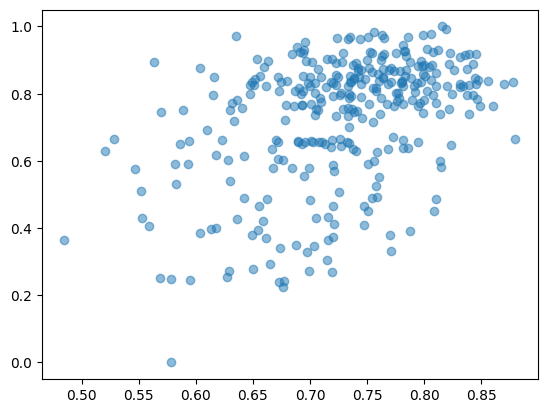

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(preds, labels, alpha=0.5)
plt.show()

In [27]:
training_args2 = TrainingArguments(
    output_dir = 'emotion_regression',
    learning_rate = 1e-4,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 8,
    logging_steps = 10,
    num_train_epochs = 40,
    weight_decay = 0.10,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = False,
    report_to = None,
    lr_scheduler_type = 'polynomial',
    lr_scheduler_kwargs = { 'power': 2, 'lr_end': 1e-8 },
)

In [30]:
trainer2 = CustomTrainer2(
    model = model,
    args = training_args2,
    train_dataset = dataset['train'],
    eval_dataset = dataset['val'],
    compute_metrics = compute_metrics,
)


In [31]:
train_result = trainer2.train()

Epoch,Training Loss,Validation Loss,Pearson
1,0.537700,0.555601,0.401572
2,0.693900,0.557720,0.400848
3,0.594700,0.554453,0.401670
4,0.585700,0.556185,0.401126
5,0.571400,0.554270,0.401621
6,0.588600,0.555070,0.401496
7,0.568600,0.553794,0.402261
8,0.582100,0.553567,0.402591
9,0.539800,0.555962,0.401350
10,0.574700,0.553293,0.402845


In [32]:
out = trainer.predict(dataset_train)

In [ ]:
train_result = trainer.train()

#### Let's check the results
* I wrapped in a function a convenient way add the predictions

In [ ]:
from tqdm.auto import tqdm, trange
def make_predictions(model, df):


  # Convert summaries to a list
  sentences = df.input.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in trange(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])

  final_outputs = torch.cat(all_outputs, dim=0)
  df['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df['predictions']=df['predictions'].apply(lambda l:category_map[l])




### Analyze performance

In [ ]:
def get_performance_metrics(df_test):
  y_test = df_test.score.round()
  y_pred = df_test.predictions.round()
  print(f"comparing test {y_test} and pred {y_pred}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
make_predictions(model,df_val)

get_performance_metrics(df_val)
df_val

### Saving the model trainer state and model adapters

In [ ]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

#### Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [ ]:
trainer.save_model("saved_model")

### Save to google drive
Make sure before disconnecting and deleting the Colab runtime you save your model for future inference use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!cp -r sequence_classification /content/drive/MyDrive/Colab

In [ ]:
!cp -r saved_model /content/drive/MyDrive/Colab